<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#처리-단계-명세" data-toc-modified-id="처리-단계-명세-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>처리 단계 명세</a></span></li><li><span><a href="#데이터-불러오기" data-toc-modified-id="데이터-불러오기-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>데이터 불러오기</a></span></li><li><span><a href="#카테고리-워드클라우드" data-toc-modified-id="카테고리-워드클라우드-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>카테고리 워드클라우드</a></span></li><li><span><a href="#토픽-워드클라우드" data-toc-modified-id="토픽-워드클라우드-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>토픽 워드클라우드</a></span></li><li><span><a href="#전체-기사-시계열-그래프" data-toc-modified-id="전체-기사-시계열-그래프-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>전체 기사 시계열 그래프</a></span></li><li><span><a href="#토픽-별-시계열-그래프" data-toc-modified-id="토픽-별-시계열-그래프-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>토픽 별 시계열 그래프</a></span></li></ul></div>

In [139]:
import modules.newsight as ns 

# 시각화
import matplotlib.pyplot as plt
import seaborn as sb

# file I/O
import pickle
import pandas as pd

import numpy as np # 연산
import time # 연산 시간 측정

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings("ignore")

## 처리 단계 명세

**DB** workflow v3 전처리(토큰화).ipynb  

1. **검색어 입력**
2. **데이터 불러오기**(raw data)   
1. **전처리**  
    1.1. 특수문자, 일반적 불용어 제거  
    1.2. 유효 명사 추가     
    1.4. 검색어에 대한 불용어 제거  
    1.3. 명사 추출  

**Backend** workflow v3 유효기사추출 - 대표기사추출.ipynb 

1. **검색어 입력**
2. **데이터 불러오기**(tokenized data)
3. **유효문서 추출**  
    3.2. 유효 문서 추출 A (제목에 검색어를 포함하는 문서만 추출, 제목에 [ ]가 들어간 문서 제외)  
    3.3. 유효 문서 추출 B (본문에 검색어가 3번 이상 들어가는 문서만 추출) 
4. **문서별 카테고리 할당**
5. **카테고리 별 토픽 할당**  
    5.1. 벡터화 (TFIDF)  
    5.2. 군집화 (DBSCAN)
6. **토픽 별 대표기사 추출**
    6.1. 토픽별 문서 벡터화 (TFIDF)  
    6.2. 토픽별 대표 키워드 추출 (SVD)  
    6.3. 토픽별 대표 문서 추출 (BM25)  
    
**Frontend** <font color='red'> workflow v3 시각화.ipynb </font>

1. 카테고리 워드클라우드 or 그래프  
2. 토픽 워드클라우드  

3. 전체 기사 시계열 그래프  
4. 카테고리내 토픽(날짜 : 대표기사, 빈도 : 토픽 수) 그래프  

    
**References**  
[1] 현호\_mulcam_mirae_workflow.ipynb

**기타**  
각 블록 마다 running time 측정

In [140]:
# newsight 모듈
ns.readme()

******Description*****
code by 현호킴, description by 승현백
클래스 이름.help() : 해당 클래스에서 사용할 수 있는 함수 출력
******Class names******
1) 데이터 불러오기 : Pickle2DF
2) 전처리 : PreprocessingText
3) 불용어,유의어 처리 : GetSimilarWords, GetStopWords
4) 문서 검색 :  GetDocsFromQuery
5) 벡터화 :  Vectorizer
6) 시각화 : Get2DPlot, AnalyzingNewsData, WordCloud
7) 이상치 제거 : CleaningNoise
8) 키워드 추출 : GetKeyword
수정사항은 history 함수를 참고하세효


## 데이터 불러오기

In [141]:
df_main_route = 'tokenized data/df_main.pickle' # 대표기사
df_final_route = 'tokenized data/df_final.pickle'

loader = ns.Pickle2DF()

with open(df_main_route, 'rb') as handle:
    df_main = pickle.load(handle)
    
with open(df_final_route, 'rb') as handle:
    df_final = pickle.load(handle)

print(f'''
df_final : {df_final.shape}\n
df_main : {df_main.shape}
''')


df_final : (468, 9)

df_main : (31, 9)



In [142]:
# df_final.drop(df_final[df_final['topic']==-1].index,inplace = True)
# df_main.drop(df_main[df_main['topic']==-1].index,inplace = True)

## 카테고리 워드클라우드

In [143]:
def make_wordcloud(word_list):
    from collections import Counter
    from wordcloud import WordCloud
    
    cnt = Counter(word_list)
    tags = cnt.most_common(20)
    
    wc_obj = WordCloud(width = 800, height = 800, 
                    font_path = 'data/H2GTRE.TTF',    
                    background_color ='white', 
                    min_font_size = 10)

    cloud = wc_obj.generate_from_frequencies(dict(tags))
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(cloud) 
    plt.axis("off") 
    plt.tight_layout() 

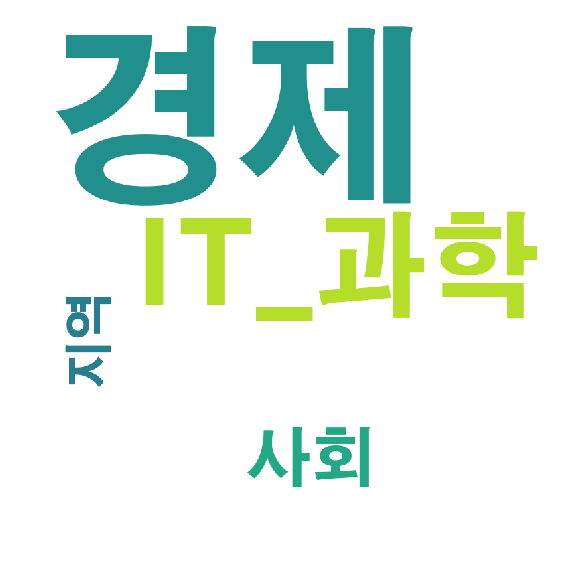

In [144]:
cat_list = df_final['cat_selected'].values.tolist()
make_wordcloud(cat_list)

## 토픽 워드클라우드
* 제목만 가지고 만드는 방안도 고려
* DB에서 제목도 토큰화

In [145]:
df_final.head()12

,date,title,content,category,date_tmp,tokenized_doc,tokenized_title,cat_selected,topic
0,2019-04-19,"미래에셋대우-에트리홀딩스, 중소·벤처기업 성장지원 업무 협약",[ 이송렬 기자 ] \n \n미래에셋대우는 미래에셋센터원에서 에트리홀딩스(주)와 '...,[경제>산업_기업],737168,"[미래에셋대우, 미래에셋센터원, 에트리홀딩스, 중소, 벤처기업, 성장지원, 업무, ...","[미래에셋대우, 에트리홀딩스, 중소, 벤처기업, 성장지원, 업무, 협약]",경제,-1
1,2019-04-19,"미래에셋대우, 에트리홀딩스와 `중소·벤처기업 성장 지원` MOU 체결",미래에셋대우는 지난 18일 서울 중구 미래에셋센터원에서 에트리홀딩스와 '중소·벤처 ...,"[경제>산업_기업, 경제>취업_창업]",737168,"[미래에셋대우, 서울, 중구, 미래에셋센터원, 에트리홀딩스, 중소, 벤처, 기업, ...","[미래에셋대우, 에트리홀딩스, 중소, 벤처기업, 성장, 지원, 체결]",경제,-1
2,2019-04-19,홍콩 오피스 빌딩에 2800억 투자한 미래에셋대우,[디지털타임스 차현정 기자] 미래에셋대우는 18일 홍콩 CBD2(이스트 카우룽)에 ...,"[경제>국제경제, 경제>금융_재테크, 경제>산업_기업]",737168,"[디지털타임스, 미래에셋대우, 홍콩, 이스트, 카우룽, 위치, 오피스, 빌딩, 골딘...","[홍콩, 오피스, 빌딩, 투자, 미래에셋대우]",경제,12
3,2019-04-18,홍콩 오피스 빌딩에 2800억 투자한 미래에셋대우,[디지털타임스 차현정 기자] 미래에셋대우는 18일 홍콩 CBD2(이스트 카우룽)에 ...,"[경제>국제경제, 경제>금융_재테크, 경제>산업_기업]",737167,"[디지털타임스, 미래에셋대우, 홍콩, 이스트, 카우룽, 위치, 오피스, 빌딩, 골딘...","[홍콩, 오피스, 빌딩, 투자, 미래에셋대우]",경제,12
4,2019-04-18,해외 부동산 쓸어담는 미래에셋대우,쾰른·파리 찍고 다시 홍콩…새 업무지구 빌딩에 2800억 투자 \n \n내달 5억弗...,"[경제>금융_재테크, 경제>산업_기업, 경제>국제경제]",737167,"[쾰른, 파리, 홍콩, 새, 업무지구, 빌딩, 투자, 내달, 채권, 발행, 실탄, ...","[해외, 부동산, 어담, 미래에셋대우]",경제,12


*************category : 경제, topic : 1*************


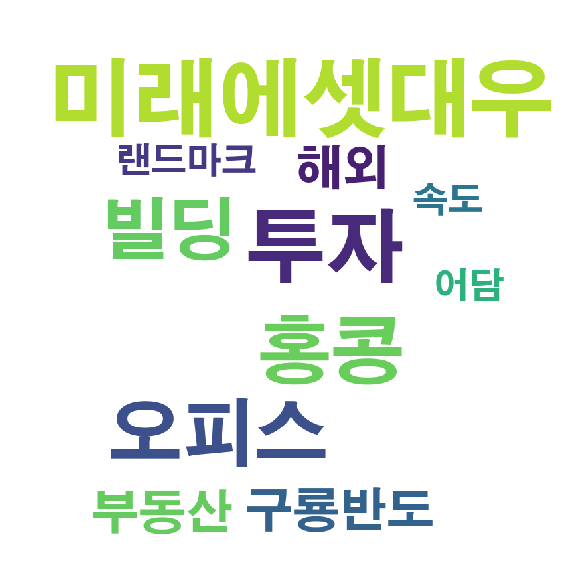

In [149]:
# 경제 - topic : 1
df_cat = df_final[df_final['cat_selected']=='경제']
df_cat_topic = df_cat[df_cat['topic']==12]
tk_docs = df_cat_topic['tokenized_title'].values.tolist()
tmp = []
for tk in tk_docs:
    tmp.extend(tk)
print(f'*************category : 경제, topic : 1*************')
make_wordcloud(tmp)  

## 전체 기사 시계열 그래프

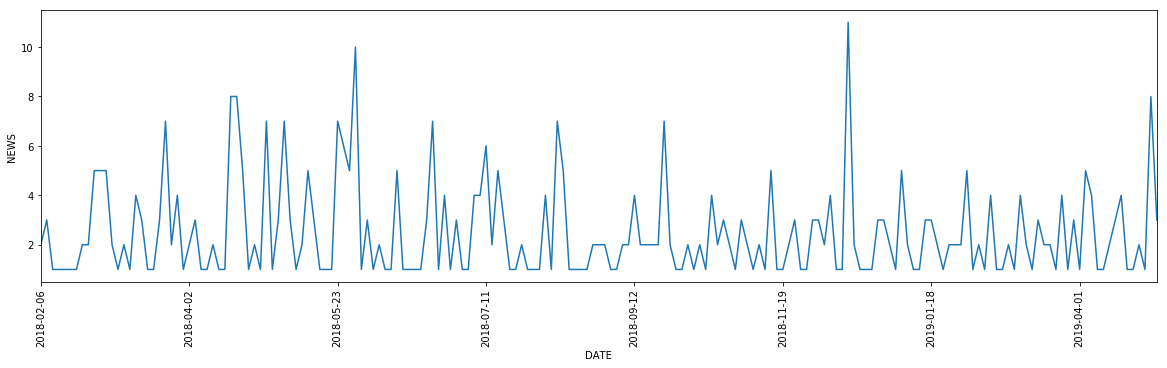

In [150]:
n_docs_date = df_final.groupby(['date'])['title'].count()
plt.figure(figsize = (20,5))

n_docs_date.plot()

plt.xticks(rotation = 'vertical')
plt.xlabel('DATE')
plt.ylabel('NEWS')

plt.show()

## 토픽 별 시계열 그래프

In [151]:
# 경제
# {대표 기사의 날짜 : 대표 기사가 속한 토픽의 기사 수}

n_docs_topic = df_final[df_final['cat_selected']=='경제'].groupby(['topic'])['title'].count() # n docs per topic
main_doc_date = df_main[df_main['cat_selected']=='경제'].sort_values(by= 'date' , ascending = True)
main_doc_date['n_docs_topic'] = main_doc_date['topic'].apply(lambda x : n_docs_topic[x])
main_doc_date = main_doc_date.drop(main_doc_date[main_doc_date['topic']==-1].index).reset_index(drop = True) # 토픽 = -1 제거

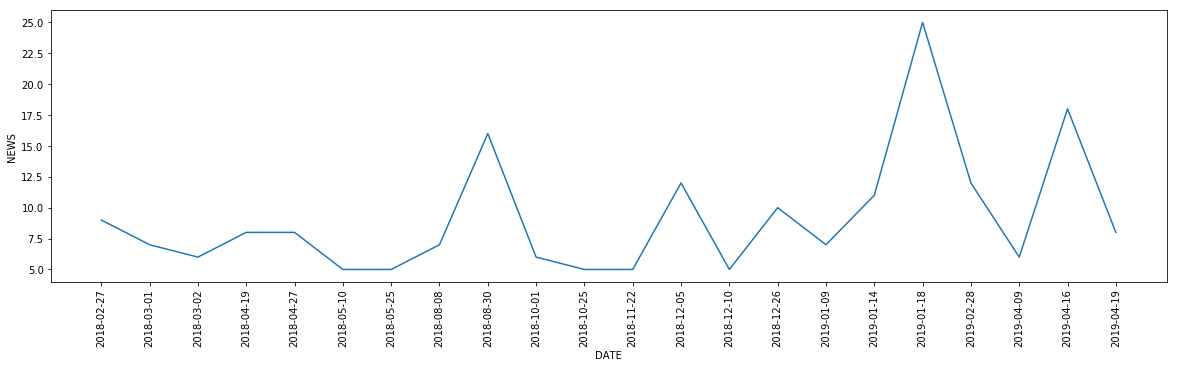

In [152]:
plt.figure(figsize = (20,5))
plt.plot(main_doc_date['n_docs_topic'])
x = list(range(main_doc_date.shape[0]))
labels = main_doc_date['date'].values.tolist()
plt.xticks(x,labels, rotation = 90)
plt.xlabel('DATE')
plt.ylabel('NEWS')
plt.show()